In [1]:
import numpy as np                          # Operaciones numéricas eficientes en matrices
import pandas as pd                         # Estructuras y análisis de datos tabulares
import json                                 # Manipulación de objetos JSON
import jsonlines                            # Lectura y escritura de archivos JSON en formato de líneas
from sklearn.compose import ColumnTransformer  # Transformaciones de columnas en un estimador de flujo de trabajo
from sklearn.preprocessing import OneHotEncoder  # Codificación one-hot para variables categóricas
from sklearn.preprocessing import StandardScaler  # Escalado de características
from sklearn.compose import make_column_selector  # Selector de columnas basado en tipos de datos
from sklearn.pipeline import Pipeline       # Construcción de canalizaciones de transformación y modelado
from sklearn.impute import SimpleImputer    # Imputación de valores faltantes
from sklearn import preprocessing          # Preprocesamiento de datos
import imblearn                            # Técnicas de remuestreo y equilibrio de clases
import matplotlib.pyplot as plt            # Creación de gráficos y visualización de datos
import xgboost as xgb                       # Implementación de algoritmos de XGBoost
from xgboost import XGBClassifier          # Clasificador XGBoost
from sklearn.model_selection import train_test_split  # División de datos en conjuntos de entrenamiento y prueba
from sklearn.preprocessing import LabelEncoder       # Codificación de etiquetas
from sklearn.metrics import average_precision_score  # Cálculo del promedio de precisión
from scipy import stats                     # Funciones estadísticas y matemáticas avanzadas
from sklearn.metrics import roc_curve, mean_squared_error, roc_auc_score, precision_score  # Métricas de evaluación
from sklearn.metrics import precision_recall_curve, auc, confusion_matrix, recall_score
from sklearn.metrics import accuracy_score, cohen_kappa_score, classification_report
from sklearn.metrics import fbeta_score, make_scorer, f1_score
from sklearn.model_selection import train_test_split  # División de datos en conjuntos de entrenamiento y prueba
from sklearn.model_selection import GridSearchCV     # Búsqueda exhaustiva de hiperparámetros en cuadrícula
from sklearn.model_selection import StratifiedKFold   # División estratificada de datos para validación cruzada
from sklearn.model_selection import RandomizedSearchCV  # Búsqueda aleatoria de hiperparámetros
import time                                    # Funciones relacionadas con el tiempo
from sklearn.preprocessing import StandardScaler  # Escalado de características
from sklearn.linear_model import LogisticRegression  # Regresión logística
from sklearn.tree import DecisionTreeClassifier       # Árbol de decisión
from sklearn.svm import SVC                           # Máquinas de vectores de soporte
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from scipy.stats import randint, uniform
import seaborn as sns



In [2]:
import sys
sys.path.append('C:/Users/medinaj/OneDrive - SierraCol Energy/sierracol_2022/Meli_J/challenge-ml/')

In [3]:
from data.raw.new_or_used import build_dataset
from data.processed.seller_address_transformer import SellerAddressTransformer
from data.processed.shipping_transformer import ShippingTransformer
from data.processed.tags_transformer import TagsTransformer
from data.processed.payment_methods_transformer import PaymentMethodsTransformer
from data.processed.warranty_transformer import WarrantyTransformer

In [4]:
# Obtener los datos
X_train, y_train, X_test, y_test = build_dataset()

# Convertir en dataframes
df_X_train = pd.DataFrame(X_train)
df_X_test = pd.DataFrame(X_test)
df_y_train = pd.DataFrame({"condition": y_train})
df_y_test = pd.DataFrame({"condition": y_test})

In [5]:
# Assign 'id' column for df_X_train from 1 to 90,000
df_X_train['id'] = range(1, len(df_X_train) + 1)

# Assign 'id' column for df_X_test from 1 to 10,000
df_X_test['id'] = range(1, len(df_X_test) + 1)


# Añadir df_y_test al df_X_test
df_X_test['condition'] = df_y_test

# Selecting the relevant columns
df_nlp = df_X_train[['id', 'condition', 'title']]
df_nlp_test = df_X_test[['id', 'condition', 'title']]

In [6]:
df_save_category = pd.read_csv('C:\\Users\\medinaj\\OneDrive - SierraCol Energy\\sierracol_2022\\Meli_J\\challenge-ml\\data\\processed\\df_save.csv', sep='|')

In [7]:
# Filtrar df_save_category
df_save_category_train = df_save_category[df_save_category['dataset'] == 'train']
df_save_category_test = df_save_category[df_save_category['dataset'] == 'test']

# Merge con df_X_train
df_X_train = pd.merge(df_X_train, df_save_category_train, on='id', how='left')
df_X_test = pd.merge(df_X_test, df_save_category_test, on='id', how='left')

In [8]:
def process_dataframe(df):
    sat = SellerAddressTransformer()
    st = ShippingTransformer()
    tt = TagsTransformer()
    pmt = PaymentMethodsTransformer()
    wt = WarrantyTransformer() 
    
    # Apply transformations and get processed DataFrames
    seller_address_normalized = sat.transform(df)
    shipping_normalized = st.transform(df)
    df = tt.transform(df)
    df = pmt.transform(df)
    df["warranty"] = df["warranty"].apply(wt.transform)


    # Calculo de la columna 'listing_type_id'
    mapeo = {'bronze': 'bronze', 'free': 'free', 'silver': 'silver', 'gold_special': 'superior',
             'gold': 'superior', 'gold_premium': 'superior', 'gold_pro': 'superior'}
    df['listing_type2'] = df['listing_type_id'].replace(mapeo)
    df['listing_type'] = df['listing_type2'].replace({'bronze': 1, 'free': 0, 'superior': 3, 'silver': 2})

      # Calculo de las columnas de fechas
    date_columns = ['last_updated', 'date_created']
    for col in date_columns:
        df[col] = pd.to_datetime(df[col])
        df[col] = df[col].dt.tz_localize(None)
        df[f'days_{col}'] = (pd.Timestamp.now().normalize() - df[col].dt.normalize()).dt.days

    # Calculo de las columnas de fechas
    date_columns = ['stop_time', 'start_time']
    for col in date_columns:
        df[col] = pd.to_datetime(df[col],format='%Y-%m-%d %H:%M:%S')
        df[col] = df[col].dt.tz_localize(None)
        df[f'days_{col}'] = (pd.Timestamp.now().normalize() - df[col].dt.normalize()).dt.days

    # Calculo de la columna 'dif_vendidos'
    df['dif_vendidos'] = df['available_quantity'] - df['sold_quantity']

   # Eliminar columnas innecesarias
    cols_delete = ['seller_address', 'sub_status', 'deal_ids',
       'shipping', 'non_mercado_pago_payment_methods',
       'seller_id', 'variations', 'site_id', 'listing_type_id', 
       'attributes', 'buying_mode', 'tags', 'listing_source', 'parent_item_id',
       'coverage_areas', 'category_id', 'descriptions', 'last_updated',
       'international_delivery_mode', 'pictures', 'id', 'official_store_id',
       'differential_pricing', 'accepts_mercadopago', 'original_price',
       'currency_id', 'thumbnail', 'title', 'automatic_relist', 'date_created',
       'secure_thumbnail', 'stop_time', 'status', 'video_id',
       'catalog_product_id', 'subtitle', 'start_time',
       'permalink','listing_type_id','listing_type2','base_price','initial_quantity',
       'non_mercado_pago_payment_methods_count2','available_quantity','days_stop_time', 'days_start_time',
       'seller_contact', 'location' , 'geolocation', 'Document', 'Category', 'dataset']
    
    df = df.drop(columns=cols_delete, errors='ignore') 

    df=pd.concat([df,seller_address_normalized['seller_address_stateid']
                      ], axis=1)

    return df

In [9]:
X_train1 = process_dataframe(df_X_train)
X_train1 = X_train1.drop(columns=['condition'])
X_test1 = process_dataframe(df_X_test)
X_test1 = X_test1.drop(columns=['condition'])

c:\Users\medinaj\OneDrive - SierraCol Energy\sierracol_2022\Meli_J\challenge-ml\data\processed\tags_transformer.py:6: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  expanded_tags = df['tags'].apply(pd.Series).add_suffix('_tags')
c:\Users\medinaj\OneDrive - SierraCol Energy\sierracol_2022\Meli_J\challenge-ml\data\processed\tags_transformer.py:6: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  expanded_tags = df['tags'].apply(pd.Series).add_suffix('_tags')


In [10]:
# Creamos las variables binarias
df_dummies = pd.get_dummies(X_train1['seller_address_stateid'], drop_first=True)
df_dummies = df_dummies.rename(columns={'AR-C': 'seller_address_stateid_AR-C','OTHER': 'seller_address_stateid_OTHER'})
X_train1 = X_train1.drop(columns=['seller_address_stateid'])
X_train1 = pd.concat([X_train1,df_dummies],axis=1)

In [11]:
# Creamos las variables binarias
df_dummies2 = pd.get_dummies(X_test1['seller_address_stateid'], drop_first=True)
df_dummies2 = df_dummies2.rename(columns={'AR-C': 'seller_address_stateid_AR-C','OTHER': 'seller_address_stateid_OTHER'})
X_test1 = X_test1.drop(columns=['seller_address_stateid'])
X_test1 = pd.concat([X_test1,df_dummies2],axis=1)

In [12]:
num_cols = ['price', 'sold_quantity','non_mercado_pago_payment_methods_count','listing_type',
            'days_last_updated', 'days_date_created', 'dif_vendidos',]
dum_cols = ['tags_dragged_bids_and_visits','shipping_local_pick_up','shipping_mode_me2',
            'seller_address_stateid_AR-C','seller_address_stateid_OTHER']

scaler = StandardScaler()
X_train1[num_cols] = scaler.fit_transform(X_train1[num_cols])
X_test1[num_cols] = scaler.transform(X_test1[num_cols])

In [13]:
y_train_dummy = pd.get_dummies(df_y_train)
y_test_dummy = pd.get_dummies(df_y_test)

# Referencia 'condition_new' = 1 --> Nuevo
y_train = y_train_dummy['condition_new']
y_test = y_test_dummy['condition_new']

In [14]:
# Definir los rangos de valores para los hiperparámetros a ajustar
param_dist = {
    'learning_rate': uniform(0.01, 0.3),
    'max_depth': randint(3, 10),
    'n_estimators': randint(100, 500),
}

# Crear el clasificador de XGBoost
model = xgb.XGBClassifier()

# Realizar la búsqueda aleatoria
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    scoring='accuracy',
    n_iter=10,
    cv=5,
    random_state=42
)
random_search.fit(X_train1, y_train)

# Obtener los mejores hiperparámetros y el mejor modelo
best_params = random_search.best_params_
best_model = random_search.best_estimator_

In [15]:
print("Best Model: {}".format(best_model))
print("Best params: {}".format(best_params))

Best Model: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.12236203565420874,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=370, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)
Best params: {'learning_rate': 0.12236203565420874, 'max_depth': 7, 'n_estimators': 370}


In [16]:
modelXG = XGBClassifier(#n_jobs=-1, 
                        seed=1234,
                        #colsample_bytree = 1.0,
                        learning_rate = 0.12236203565420874, 
                        max_depth = 7, 
                        #min_child_weight = 10.0, 
                        n_estimators = 370)

modelXG.fit(X_train1, y_train)
print(modelXG)

y_predXG = modelXG.predict(X_test1)
predictionsXG = [round(value) for value in y_predXG]

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.12236203565420874,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=370, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)


## Prediction and Confusion Matrix

Accuracy: 0.86
F1 Score: 0.87
Precision: 0.88
Recall: 0.85


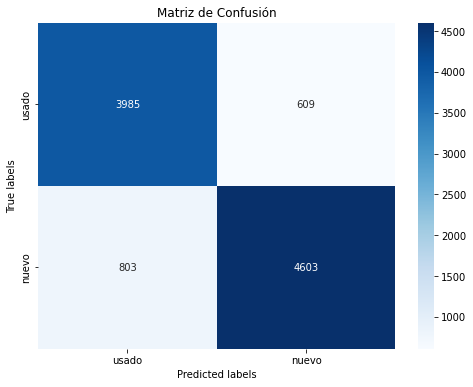

In [17]:
# Predicciones
y_train_predXG = modelXG.predict(X_train1)

# Obtenemos la matriz de confusión a partir de los resultados obtenidos
confusionMatrixXG = confusion_matrix(y_test, y_predXG)

# Calcular métricas
print("Accuracy:", round(accuracy_score(y_test, y_predXG), 2))
print("F1 Score:", round(f1_score(y_test, y_predXG), 2))
print("Precision:", round(precision_score(y_test, y_predXG), 2))
print("Recall:", round(recall_score(y_test, y_predXG), 2))

# Construir la matriz de confusión
# Suponiendo que tus etiquetas son 1 para 'nuevo' y 0 para 'usado'
cm = confusionMatrixXG

# Visualizar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['usado', 'nuevo'], yticklabels=['usado', 'nuevo'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Matriz de Confusión')
plt.show()


## Curva ROC

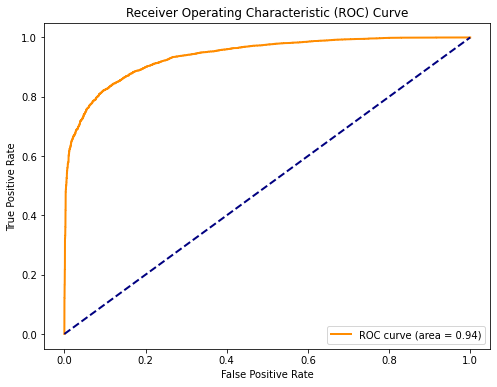

In [18]:
y_prob = modelXG.predict_proba(X_test1)[:,1]  # Probabilidades para la clase positiva
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_score(y_test, y_prob))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

El área bajo la curva ROC (AUC) también se considera una métrica para evaluar la calidad del modelo. Cuanto más cerca esté el valor de 1, mejor será tu modelo; mientras que un valor de 0.5 (la línea diagonal) indica un modelo no mejor que una asignación aleatoria.